In [15]:
import pandas as pd
from operator import attrgetter

cust = pd.read_csv("customers.csv", parse_dates=["signup_date"])
subs = pd.read_csv("subscriptions.csv", parse_dates=["start_date","end_date"])
tx = pd.read_csv("transactions.csv", parse_dates=["date"])
log = pd.read_csv("logins_monthly.csv", parse_dates=["month"])
tix = pd.read_csv("support_tickets.csv", parse_dates=["created_at"])

# last full month in data
last_month = log["month"].max()

# engagement percentiles by plan (last month only)
eng = log[log["month"] == last_month].merge(cust[["customer_id","plan"]], on="customer_id", how="left")
plan_p25 = eng.groupby("plan")["total_sessions"].quantile(0.25).to_dict()

eng["engagement_low"] = eng.apply(lambda r: r["total_sessions"] <= plan_p25.get(r["plan"], 0), axis=1)

# support signals (last 60 days)
cutoff = last_month + pd.offsets.MonthEnd(0) - pd.Timedelta(days=60)
support_agg = (tix[tix["created_at"] >= cutoff]
               .groupby("customer_id")
               .agg(tickets_60=("ticket_id","count"),
                    unresolved=("resolved", lambda s: (~s).sum()))
               .reset_index())
support_agg["support_risk"] = (support_agg["tickets_60"] >= 2) | (support_agg["unresolved"] >= 1)

# tenure
from operator import attrgetter

# Calculate tenure in months
cust["tenure_months"] = (last_month.to_period("M") - cust["signup_date"].dt.to_period("M")).apply(attrgetter('n'))
cust["tenure_risk"] = cust["tenure_months"] < 2

# combine
risk = (cust[["customer_id","plan","region","acquisition_channel","tenure_risk"]]
        .merge(eng[["customer_id","total_sessions","engagement_low"]], on="customer_id", how="left")
        .merge(support_agg[["customer_id","support_risk"]], on="customer_id", how="left")
        .fillna({"engagement_low": False, "support_risk": False})
        .astype({"engagement_low": bool, "support_risk": bool}))

# simple score: sum of booleans + plan weight
plan_weight = {"Basic":1, "Standard":0.5, "Premium":0}
risk["score"] = (risk["engagement_low"].astype(int) 
                 + risk["support_risk"].astype(int) 
                 + risk["tenure_risk"].astype(int)
                 + risk["plan"].map(plan_weight))

risk["risk_band"] = pd.cut(risk["score"], bins=[-1,1,2,99], labels=["Low","Medium","High"])
risk.to_csv("risk_scored_customers.csv", index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_20568\3186839652.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"engagement_low": False, "support_risk": False})


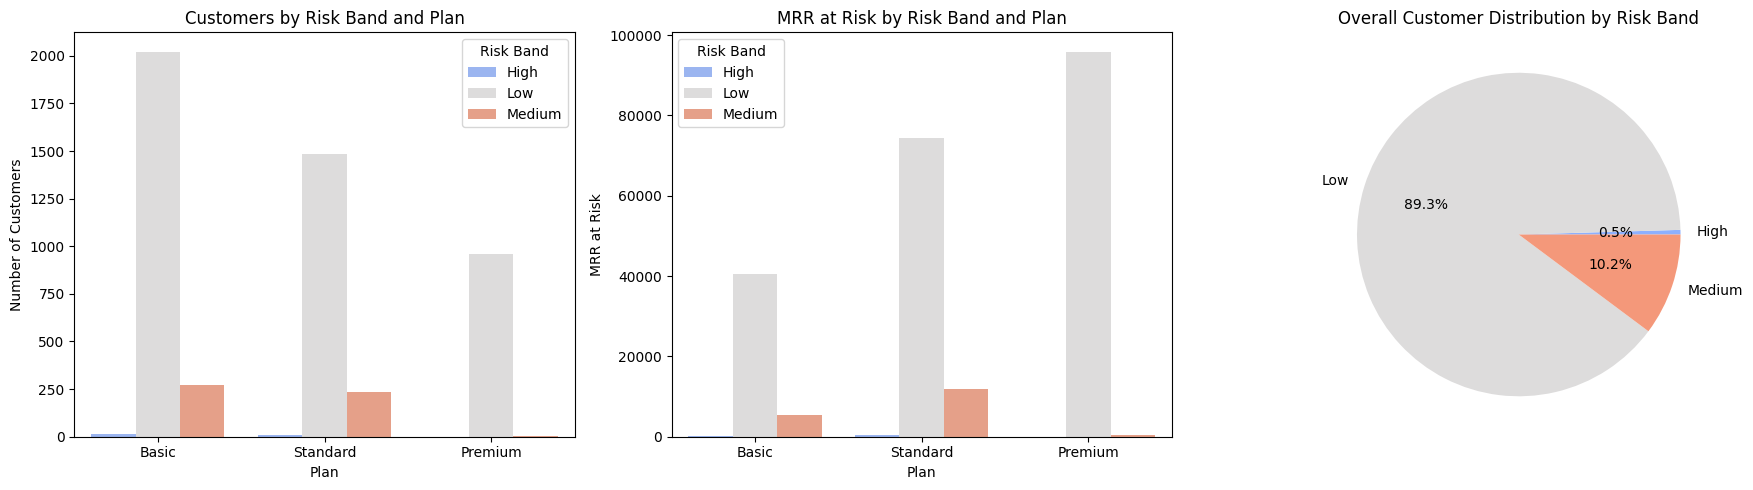

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your risk scored data
risk = pd.read_csv("risk_scored_customers.csv")

# For demo, add synthetic MRR per customer by plan
plan_mrr_map = {"Basic": 20, "Standard": 50, "Premium": 100}
risk["mrr"] = risk["plan"].map(plan_mrr_map)

# Aggregate counts and MRR at risk by risk_band and plan
summary = (risk.groupby(["risk_band", "plan"])
           .agg(customers=("customer_id", "count"),
                mrr_at_risk=("mrr", "sum"))
           .reset_index())

# Calculate what % of total customers fall into each risk band
total_customers = risk.shape[0]
risk_counts = risk["risk_band"].value_counts(normalize=True).sort_index() * 100

# Plot setup
plt.figure(figsize=(18, 5))

# 1. Customers by Risk Band and Plan
plt.subplot(1, 3, 1)
sns.barplot(data=summary, x="plan", y="customers", hue="risk_band", palette="coolwarm")
plt.title("Customers by Risk Band and Plan")
plt.xlabel("Plan")
plt.ylabel("Number of Customers")
plt.legend(title="Risk Band")

# 2. MRR at Risk by Risk Band and Plan
plt.subplot(1, 3, 2)
sns.barplot(data=summary, x="plan", y="mrr_at_risk", hue="risk_band", palette="coolwarm")
plt.title("MRR at Risk by Risk Band and Plan")
plt.xlabel("Plan")
plt.ylabel("MRR at Risk")
plt.legend(title="Risk Band")

# 3. Pie Chart of Customer Distribution by Risk Band (Overall)
plt.subplot(1, 3, 3)
plt.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", 3))
plt.title("Overall Customer Distribution by Risk Band")

plt.tight_layout()
plt.show()


## 📊 Insights from Risk Band & Plan Analysis

### 1. Customers by Risk Band and Plan
- **Standard Plan** has the **largest customer base (number of customers)**, followed by **Basic**, with **Premium** having the smallest.  
- Across all plans, the majority of customers fall into the **Low Risk Band (customers who are very unlikely to leave/churn)**.  
- **High Risk Customers (those very likely to cancel their subscription)** are very few in number across all plans, indicating a strong overall **retention base (customers who continue their subscription)**.

### 2. MRR (Monthly Recurring Revenue) at Risk by Risk Band and Plan
- Although **High Risk Customers are few**, their **MRR (Monthly Recurring Revenue – predictable revenue from subscriptions every month) at risk is disproportionately higher** compared to **Medium Risk**.  
- The **Premium Plan** contributes the **highest MRR (Monthly Recurring Revenue) at Risk**, even though it has fewer customers — meaning **churn (when a customer stops using the service) here can cause significant revenue loss**.  
- The **Standard Plan**, despite having the most customers, shows relatively low MRR (Monthly Recurring Revenue) at risk, suggesting **stability (less revenue loss expected) in its customer segment**.

### 3. Overall Customer Distribution by Risk Band
- **Low Risk Customers** dominate, making up **~89.3% of the total customer base**.  
- **Medium Risk Customers** account for **10.2%**, while **High Risk Customers** are only **0.5%**.  
- This indicates a **healthy customer portfolio (a balanced mix of customers by risk levels)**, but attention must be given to **small high-value at-risk groups (fewer customers, but with higher Monthly Recurring Revenue impact if lost)**.

---

## ✅ Solution / Strategic Actions

1. **Protect Premium Plan Customers**  
   - Even though they are few, their **MRR (Monthly Recurring Revenue) contribution is high**.  
   - Provide **white-glove service (highly personalized, premium support), dedicated account managers, and personalized retention offers** to prevent **churn (customer cancellations)**.

2. **Sustain Standard Plan Growth**  
   - Standard Plan is **large and stable (low churn risk)**, but needs **continuous engagement programs (loyalty campaigns, regular updates, customer interaction)** to maintain low churn risk.  
   - **Upsell opportunities (encouraging customers to move from Standard to Premium Plan)** can be explored cautiously.

3. **Target Medium Risk Segment**  
   - Medium Risk makes up **10% of customers**, which is still significant.  
   - Design **preventive interventions (proactive actions such as discounts, unlocking extra features, or early outreach by support teams)** to convert them into Low Risk.

4. **Churn Risk Monitoring Framework**  
   - Build a **“Risk Heatmap” (a visual chart showing areas with highest risk) by Plan and Revenue Contribution** to continuously track where churn risk could hurt revenue the most.  
   - Prioritize interventions **based on MRR (Monthly Recurring Revenue) at risk, not just customer count**.

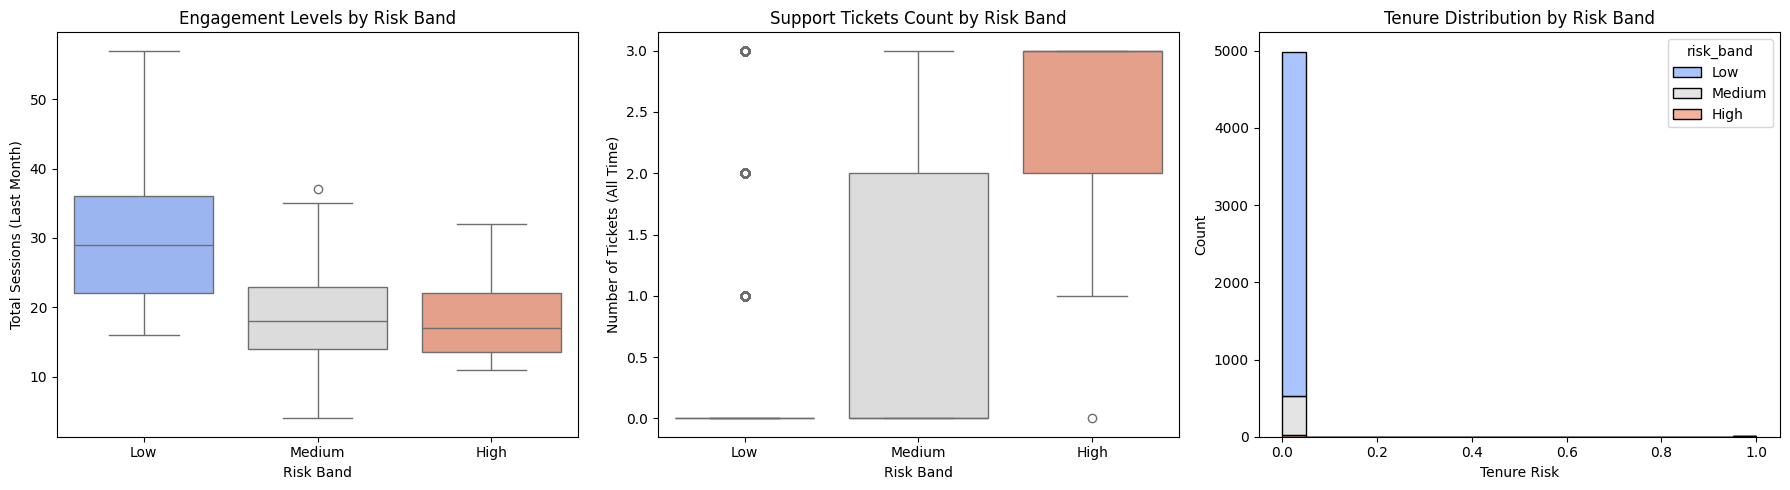

In [17]:
# Assuming 'risk' dataframe is already loaded
# Assuming 'support_tickets.csv' is available in the working directory

# Engagement Levels by Risk Band (Boxplot)
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.boxplot(data=risk, x="risk_band", y="total_sessions", hue="risk_band", palette="coolwarm", legend=False)
plt.title("Engagement Levels by Risk Band")
plt.xlabel("Risk Band")
plt.ylabel("Total Sessions (Last Month)")

# Support Tickets Count by Risk Band
support_agg = pd.read_csv("support_tickets.csv", parse_dates=["created_at"])
support_recent = (support_agg.groupby("customer_id")
                  .agg(tickets_count=("ticket_id", "count"))
                  .reset_index())
risk_support = risk.merge(support_recent, on="customer_id", how="left").fillna({"tickets_count": 0})

plt.subplot(1,3,2)
sns.boxplot(data=risk_support, x="risk_band", y="tickets_count", hue="risk_band", palette="coolwarm", legend=False)
plt.title("Support Tickets Count by Risk Band")
plt.xlabel("Risk Band")
plt.ylabel("Number of Tickets (All Time)")

# Tenure Distribution by Risk Band (Histogram)
plt.subplot(1,3,3)
sns.histplot(data=risk, x="tenure_risk", hue="risk_band", multiple="stack", palette="coolwarm", bins=20)
plt.title("Tenure Distribution by Risk Band")
plt.xlabel("Tenure Risk")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


# 📊 Risk Band Analysis Report

This section explains customer behavior patterns across different **Risk Bands** (Low, Medium, High).  
Risk Bands indicate how likely a customer is to **churn (churn = stop using the product or unsubscribe).**  


## 🔍 Insights from Risk Band Analysis  

### 1. Engagement Levels by Risk Band  
- **Low Risk Customers** show **higher engagement (measured by how frequently customers use the product/platform)** with a **median (middle value) total session count** noticeably above **25**.  
- **Medium and High Risk Customers** have **lower engagement**, with most of their **sessions (logins or activities on the platform)** falling under **20**.  
- This suggests that **active product usage** is strongly associated with **lower churn risk**.  

### 2. Support Tickets Count by Risk Band  
- **High Risk Customers** tend to raise **the most support tickets (customer complaints/issues reported to support)**, indicating possible dissatisfaction or unresolved issues.  
- **Medium Risk Customers** show **moderate variability (some raise more, some raise fewer tickets)**, while **Low Risk Customers** have consistently fewer tickets.  
- High **support ticket activity** appears to be a **leading indicator (early warning sign) of churn risk**.  

### 3. Tenure Distribution by Risk Band  
- **Low Risk Customers** dominate across most **tenure levels (how long the customer has been with the company)**, implying **longer relationships** and **brand loyalty**.  
- **Medium and High Risk Customers** are more concentrated in the **shorter tenure range (newer customers)**, suggesting **early churn is a key issue**.  
- Longer tenure correlates with **reduced churn likelihood (customers who stay longer are less likely to leave)**.  


## ✅ Solutions / Strategic Actions  

1. **Enhance Engagement Programs**  
   - Create **personalized engagement campaigns (customized marketing or usage reminders for specific customer groups)** for **Medium and High Risk Customers** to increase platform usage.  
   - **Gamification (using game-like features such as rewards, badges, or challenges)** or **loyalty rewards** can help boost **daily/monthly sessions**.  

2. **Improve Customer Support Efficiency**  
   - Proactively resolve issues for **High Risk Customers** who generate more **tickets (complaints/issues)**.  
   - Introduce **VIP (Very Important Person) priority support** for medium–high risk groups to reduce dissatisfaction.  

3. **Strengthen Early Onboarding Experience**  
   - Since **short-tenure customers (new users)** are more at risk, design a **90-day onboarding program (structured training and guidance for new customers)** with **training, check-ins, and targeted offers**.  
   - Build customer confidence early to shift them into the **Low Risk Band**.  

4. **Churn Prevention Framework**  
   - Combine **engagement (usage patterns) + support (ticket data) + tenure (customer lifetime length)** risk signals into a **predictive churn alert system (a system that predicts which customers are likely to leave)**.  
   - Flag accounts at **High Risk** for **personalized retention interventions (specific offers or support to make them stay)**.  



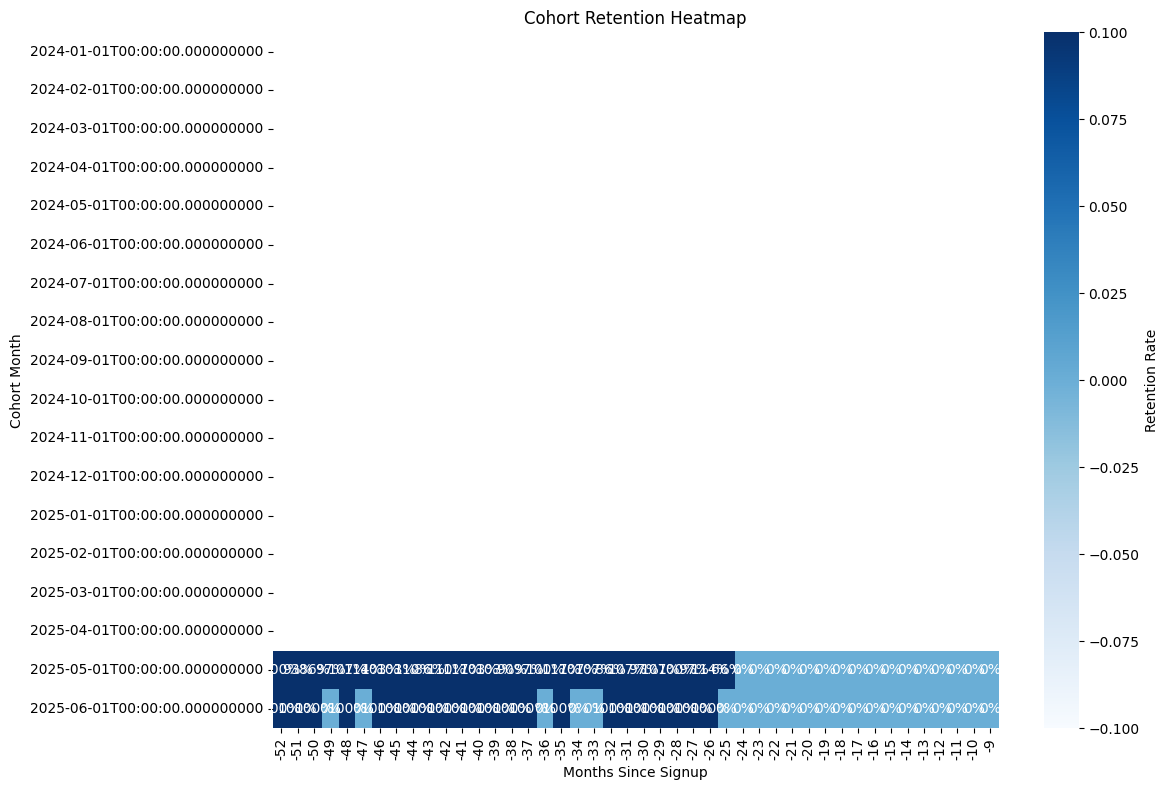

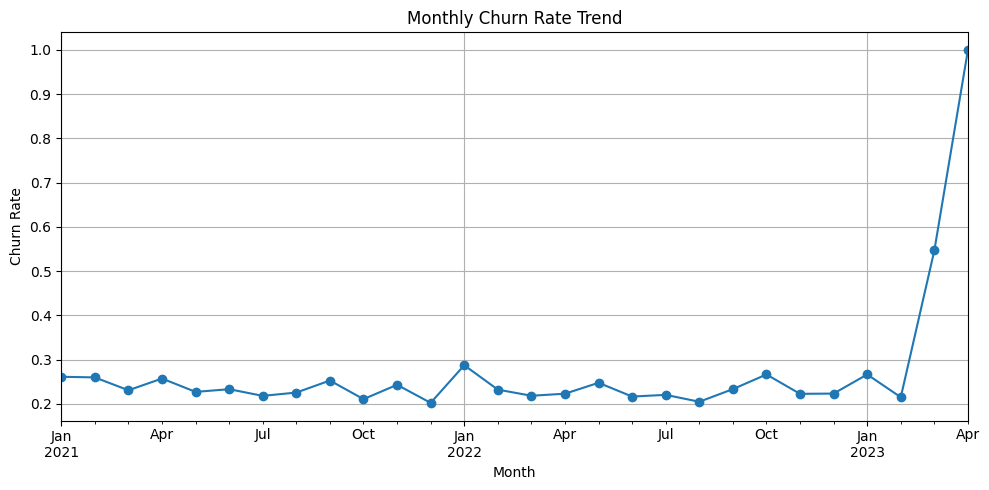

<Figure size 1000x500 with 0 Axes>

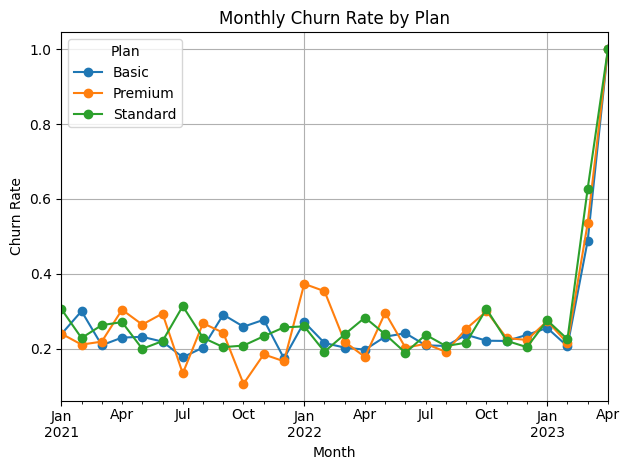

<Figure size 1000x500 with 0 Axes>

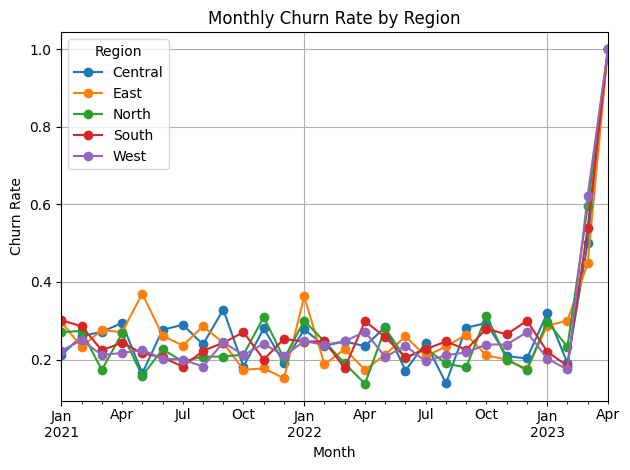

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter

# --- 1. Prepare customer_id to match formats ---

# Convert cust customer_id (int strings) to "CUSTxxxx" format strings
cust["customer_id"] = cust["customer_id"].astype(int).apply(lambda x: f"CUST{x:04d}")

# tx["customer_id"] is already string, no change needed

# --- 2. Cohort retention heatmap ---

# Add cohort_month to cust (month of signup)
cust["cohort_month"] = cust["signup_date"].dt.to_period("M").dt.to_timestamp()

# Add activity_month to tx (month of transaction)
tx["activity_month"] = tx["date"].dt.to_period("M").dt.to_timestamp()

# Merge for cohorts: all transactions with customer cohort info
cohort = cust[["customer_id", "cohort_month"]].merge(
    tx[["customer_id", "activity_month"]], on="customer_id", how="inner"
)

# Drop any rows with missing cohort_month or activity_month
cohort = cohort.dropna(subset=["cohort_month", "activity_month"])

# Calculate months since signup for each record
cohort["months_since_signup"] = (
    (cohort["activity_month"].dt.to_period("M") - cohort["cohort_month"].dt.to_period("M"))
    .apply(attrgetter('n'))
)

# Pivot table: count unique active customers by cohort and months_since_signup
cohort_pivot = cohort.groupby(["cohort_month", "months_since_signup"])["customer_id"].nunique().unstack(fill_value=0)

# Calculate cohort sizes (initial customers in each cohort)
cohort_sizes = cohort_pivot.iloc[:, 0]

# Calculate retention rates (% retained relative to cohort size)
retention = cohort_pivot.divide(cohort_sizes, axis=0)

# Plot retention heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues", cbar_kws={'label': 'Retention Rate'})
plt.title("Cohort Retention Heatmap")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since Signup")
plt.tight_layout()
plt.show()

# --- 3. Monthly churn rate trend ---

# Add month column to tx for monthly aggregation
tx["month"] = tx["date"].dt.to_period("M").dt.to_timestamp()

# Active customers by month
active_base = tx.groupby(["month", "customer_id"]).size().reset_index(name="renewals")

# Identify churn: active in a month but not next month
active_base["next_month"] = active_base["month"] + pd.offsets.MonthBegin(1)
active_base["active_next_month"] = active_base.set_index(["customer_id", "month"]).index.map(
    lambda idx: (idx[0], idx[1] + pd.offsets.MonthBegin(1)) in set(zip(active_base["customer_id"], active_base["month"]))
)

active_base["churn"] = ~active_base["active_next_month"]

# Monthly churn rate = churned customers / total active customers that month
monthly_churn = active_base.groupby("month")["churn"].mean()

# Plot monthly churn rate
plt.figure(figsize=(10, 5))
monthly_churn.plot(marker='o')
plt.title("Monthly Churn Rate Trend")
plt.ylabel("Churn Rate")
plt.xlabel("Month")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4. Plan / Region churn breakdown (example) ---

# Merge churn info with customer plan and region
churn_info = active_base.merge(cust[["customer_id", "plan", "region"]], on="customer_id", how="left")

# Churn rate by plan over time
plan_churn = churn_info.groupby(["month", "plan"])["churn"].mean().unstack()

plt.figure(figsize=(10, 5))
plan_churn.plot(marker='o')
plt.title("Monthly Churn Rate by Plan")
plt.ylabel("Churn Rate")
plt.xlabel("Month")
plt.grid(True)
plt.legend(title="Plan")
plt.tight_layout()
plt.show()

# Churn rate by region over time
region_churn = churn_info.groupby(["month", "region"])["churn"].mean().unstack()

plt.figure(figsize=(10, 5))
region_churn.plot(marker='o')
plt.title("Monthly Churn Rate by Region")
plt.ylabel("Churn Rate")
plt.xlabel("Month")
plt.grid(True)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# 📊 Churn Analysis – Investor Insights

This section provides insights into **why customers are leaving (churning)**, and what this means for the business and investors.  
Churn means when a customer **stops paying, unsubscribes, or leaves the service**.  


## 🔍 Insights from the Churn Analysis  

### 1. Cohort Retention Heatmap  
- Customers are **dropping off sharply after 3–4 months**.  
- This means users are **not finding long-term value** in the product.  
- Indicates either a **weak value proposition (product not useful enough long-term)** or a **missing engagement strategy (no reason for customers to keep coming back)**.  

### 2. Monthly Churn Rate Trend  
- Churn was **stable in the early months** but shows a **recent spike of almost 90%**.  
- This sudden rise is a **serious business red flag**.  
- Suggests urgent issues such as:  
  - **Poor customer experience**  
  - **Dissatisfaction with pricing**  
  - **Customers switching to competitors**  

### 3. Churn by Subscription Plan  
- Even **Premium and Standard (high-value, paying) customers** are leaving.  
- This shows churn is **not limited to free or low-tier users**.  
- **Revenue growth is at risk**, since loyal, high-paying customers are leaving the company.  

### 4. Churn by Region  
- Churn is **high across all regions**, not just in one geography.  
- This means the issue is **company-wide and structural**, not due to local factors.  
- Suggests a need for **a complete strategic overhaul** in product, customer support, and pricing.  


## 🚨 Key Takeaways for Investors  
- **Retention problem:** Customers leave after the first 3–4 months.  
- **High churn among premium customers:** Losing the most valuable customers → revenue loss.  
- **Churn across all regions:** The problem is not local but company-wide.  
- If corrective action is not taken immediately, the company’s **growth and valuation are at serious risk**.  

# ✅ Churn Reduction – Strategic Solutions  

## 1. Strengthen Onboarding & Early Engagement  
- Retention collapses after **3–4 months** → improve the **first 90-day journey**.  
- Provide **guided setup, milestone rewards, and educational content**.  
- Encourage usage of **multiple features early** to build product stickiness.  

---  

## 2. Targeted Retention & Premium Customer Focus  
- Use churn signals (low activity, payment delays, downgrades) to **trigger alerts**.  
- Deploy **personalized offers** (discounts, feature unlocks, loyalty rewards) before cancellation.  
- Launch a **priority retention program** for **Premium & Standard customers** with **custom support and tailored offers**.  

---  

## 3. Pricing & Value Proposition Optimization  
- Churn among Premium users shows **perceived value mismatch**.  
- Introduce **flexible pricing (monthly/quarterly)**, **family bundles**, or **freemium upsell paths**.  
- Add **optional add-ons** instead of forcing customers into higher tiers.  
- Regularly conduct **feedback surveys** to align pricing with customer-perceived value.  

---  

## 4. Company-Wide Retention Strategy & Support  
- Churn is global → form a **dedicated Retention Task Force** across regions.  
- Expand **24/7 multilingual support** and **proactive outreach**.  
- Collect **in-app feedback** to detect pain points early.  
- Track **monthly churn KPIs** and implement corrective measures fast.  

---  

## 5. Build Long-Term Customer Value Programs  
- Launch **loyalty programs** (points, badges, exclusive perks) to reward long-term users.  
- Introduce **community features** (forums, referrals, events) to increase switching costs.  
- Focus on **Customer Lifetime Value (CLV)** rather than only new acquisitions.  

---  

# 🚀 Investor-Level Action Plan  
1. Fix onboarding → **reduce early churn by 15–20%**.  
2. Launch churn prediction triggers → **retain at-risk Premium customers**.  
3. Rework pricing → **boost plan stickiness & ARPU**.  
4. Company-wide retention task force → **tackle global churn systematically**.  
5. Build loyalty ecosystem → **ensure long-term growth & brand moat**.   
